In [1]:
import cv2
import scipy
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Image Data Preprocessing for Puck (rondelle) Detection

This code snippet is dedicated to the preprocessing of image data for puck detection. It specifically handles images containing a puck (`images_with_puck`) and images without a puck (`images_without_puck`). The goal is to prepare the data for subsequent use in training a machine learning model for puck detection. This section reads and processes images with a puck. It uses OpenCV to read and resize images to a standard size of (224, 224). The images are also converted from BGR to RGB format. The processed images are stored in the with_puck_img list, and corresponding labels are stored in the label_with_puck_img list with a label of 1 indicating the presence of a puck.


In [4]:
with_puck_img=[]
label_with_puck_img=[]
for img in glob.glob("..\Training_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

without_puck_img=[]
label_without_puck_img=[]
for img in glob.glob("..\Training_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

This section converts the processed image data and labels into NumPy arrays for further use. It also provides information about the total number of images with and without a puck.

In [5]:
with_puck_img  = np.array(with_puck_img) 
label_with_puck_img  = np.array(label_with_puck_img) 
without_puck_img  = np.array(without_puck_img) 
label_without_puck_img  = np.array(label_without_puck_img) 

print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

Total number of puck images: 56
Total number of without puck images: 49


## Data Concatenation and Normalization

This code snippet is responsible for concatenating the processed image data and labels for further use in machine learning. It combines images with a puck (`with_puck_img`) and images without a puck (`without_puck_img`), normalizes the pixel values, and creates corresponding labels (`y`).


In [6]:
X = np.concatenate((with_puck_img,without_puck_img ), axis=0)/255.0
y = np.concatenate((label_with_puck_img,label_without_puck_img ), axis=0)

## Train-test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape

(70, 224, 224, 3)

# Evaluation of the Model on Test set

To assess the trained model's performance, a fresh test dataset is formed using frames from the 'val.avi'. The model's evaluation involves the use of a confusion matrix and ROC curve.

In [8]:
# Lists to store images and labels with puck
with_puck_img = []
label_with_puck_img = []

# Load images with puck and preprocess
for img in glob.glob("..\Test_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

# Lists to store images and labels without puck
without_puck_img = []
label_without_puck_img = []

# Load images without puck and preprocess
for img in glob.glob("..\Test_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

# Convert lists to NumPy arrays
with_puck_img = np.array(with_puck_img)
label_with_puck_img = np.array(label_with_puck_img)
without_puck_img = np.array(without_puck_img)
label_without_puck_img = np.array(label_without_puck_img)

# Display total number of images for each class
print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')

# Create the test dataset
X_test = np.concatenate((with_puck_img, without_puck_img[::5]), axis=0) / 255.0
y_test = np.concatenate((label_with_puck_img, label_without_puck_img[::5]), axis=0)




Total number of puck images: 0
Total number of without puck images: 0


# Evaluating various structure of the CNN 

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
)


def CreateCNN_Model(num_layers_cnn):
    # Assert that num_layers_cnn is an integer and within the specified range
    assert isinstance(num_layers_cnn, int), "num_layers_cnn should be an integer"
    assert num_layers_cnn in [1, 2, 3], "num_layers_cnn should be 1, 2, or 3"

    # Create a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    if num_layers_cnn >= 2:
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    if num_layers_cnn >= 3:
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## AUC metric
The Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve is used for model evaluation.

In [ ]:
AUC_metric = []

for num in [1,2,3]:

    print(f"Training for Number of layer: {num}")

    cnn_exp_model = CreateCNN_Model(num_layers_cnn=num)

    # Train the model
    history = cnn_exp_model.fit(
        X_train, y_train,
        epochs=100,  # You can adjust the number of epochs
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred = cnn_exp_model.predict(X_test)

    # Evaluate the model using ROC curve and calculate AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    AUC_metric.append(auc*100)
    print(f"The AUC for {num}-layered CNN is: {auc*100}")



    

Training for Number of layer: 1
The AUC for 1-layered CNN is: 22.73474880382775
Training for Number of layer: 2
The AUC for 2-layered CNN is: 21.022727272727273
Training for Number of layer: 3
The AUC for 3-layered CNN is: 99.99252392344498


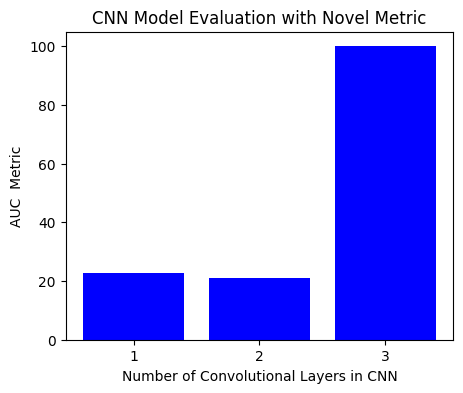

In [23]:
# Plotting the bar chart
plt.figure(figsize=(5,4))
plt.bar([1, 2, 3], AUC_metric, color='blue')
plt.xlabel('Number of Convolutional Layers in CNN')
plt.ylabel('AUC  Metric')
plt.title('CNN Model Evaluation with Novel Metric')
plt.xticks([1, 2, 3])
plt.show()

# Visualizing the embeddibgs using T-SNE

After 10 epoches


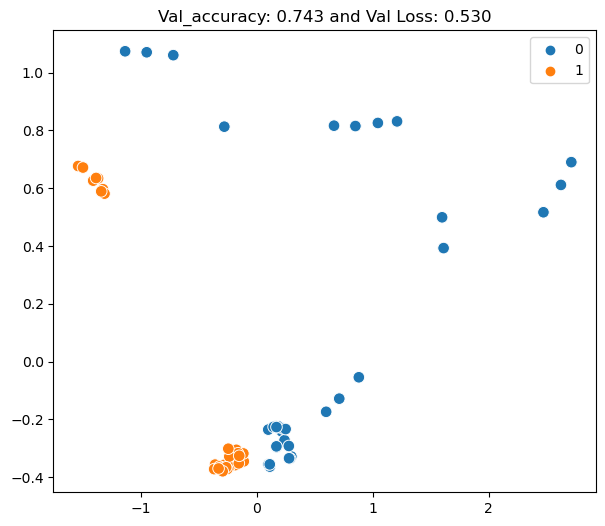

After 20 epoches


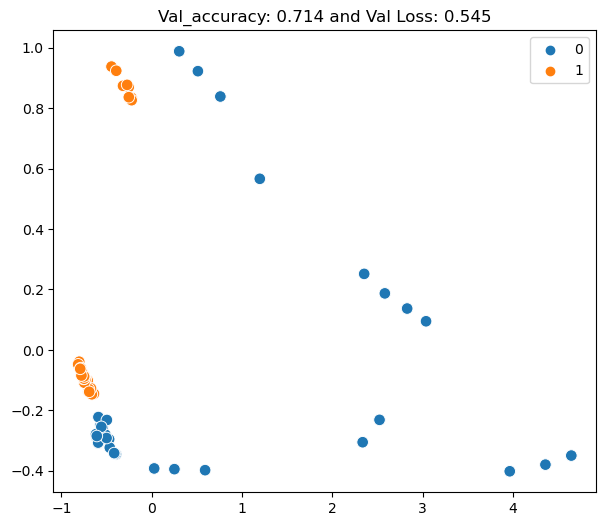

After 30 epoches


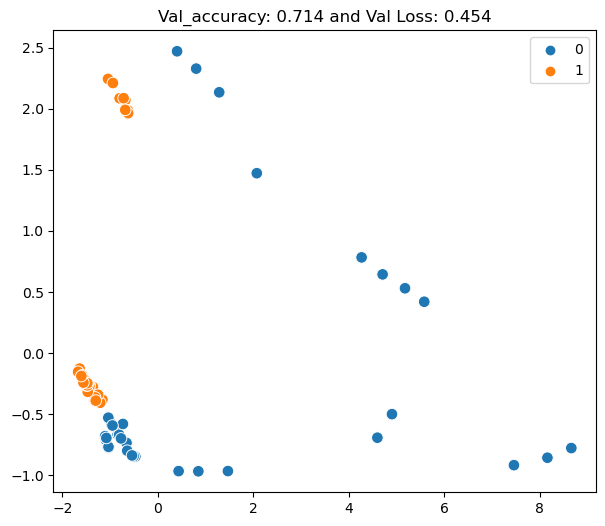

After 40 epoches


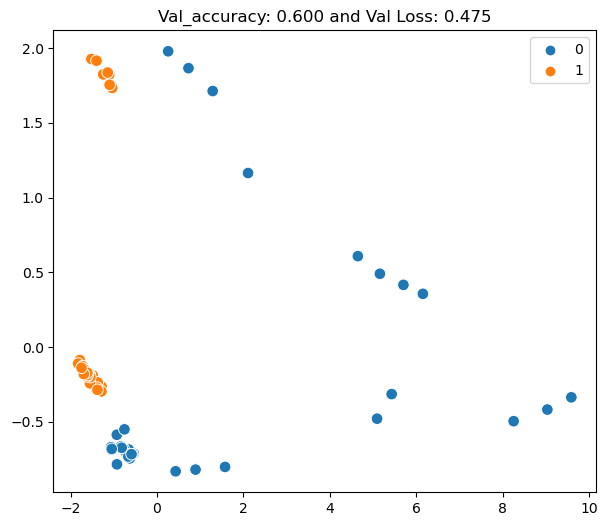

After 50 epoches


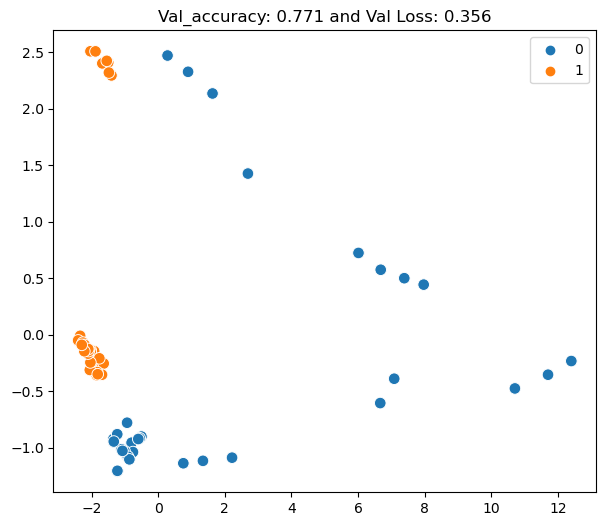

After 60 epoches


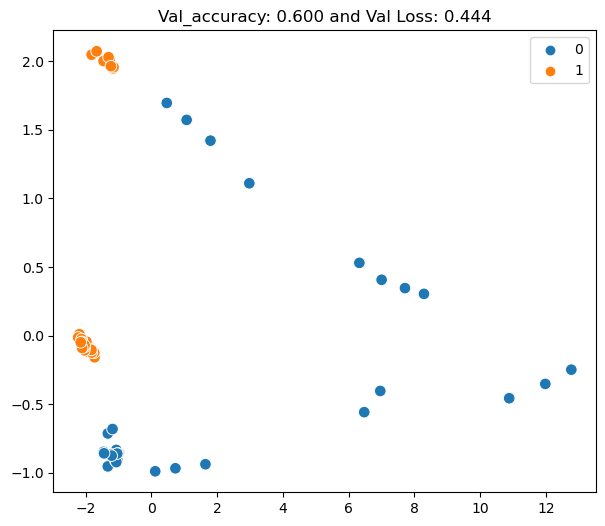

After 70 epoches


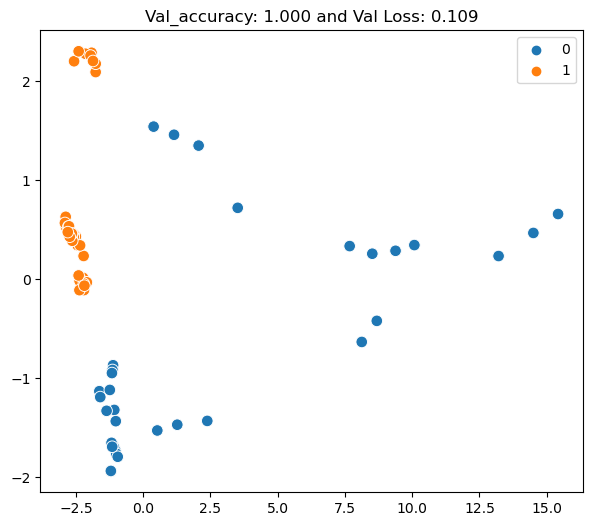

After 80 epoches


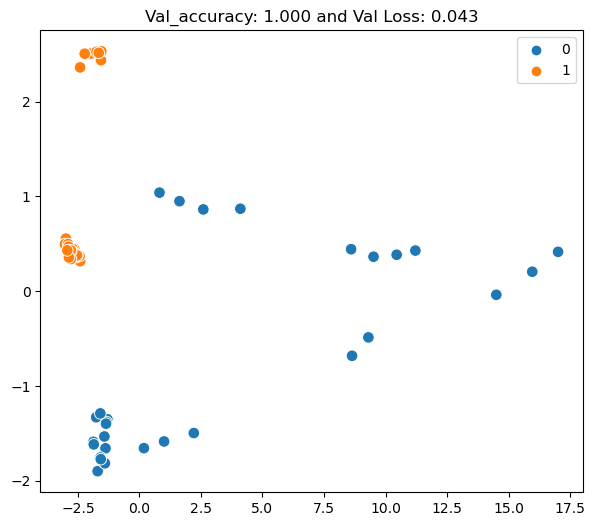

After 90 epoches


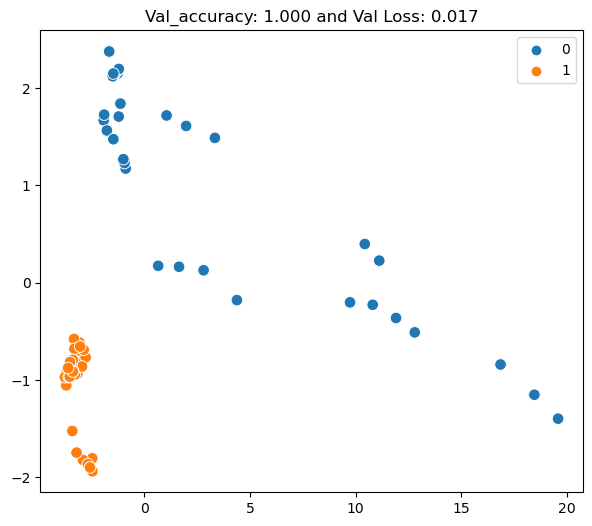

In [45]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

cnn_exp_model = CreateCNN_Model(num_layers_cnn=3)

for idx in [1,2,3,4,5,6,7,8,9,10]:
    

    # Train the model
    history = cnn_exp_model.fit(
        X_train, y_train,
        epochs=10,  # You can adjust the number of epochs
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    print(f'After {idx*10} epoches')

    val_loss = history.history['val_loss'][-1]
    val_acc =  history.history['val_accuracy'][-1]

    feature_extractor = Model(cnn_exp_model.inputs,cnn_exp_model.get_layer(index=-3).output)

    # from sklearn.manifold import TSNE

    X_embed = feature_extractor(X_train).numpy()

    tsne = PCA(n_components=2)#TSNE(n_components=2,perplexity=8, random_state=42)
    X_tsne = tsne.fit_transform(X_embed)

    # Plot the t-SNE scatter plot
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, s=70)
    plt.title(f'Val_accuracy: {val_acc:.3f} and Val Loss: {val_loss:.3f}')
    plt.show()
